In [1]:
#!pip install --user numpy pandas matplotlib wandb tqdm

In [2]:
#!pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
#!pip install --user torch-fidelity

In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

from torch_fidelity import calculate_metrics

import wandb
from tqdm.notebook import tqdm

# Preprocessing

## cuda check

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

## Load CIFAR10 dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

## WandB login

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: floowbaumgartner (floow-fhnw). Use `wandb login --relogin` to force relogin


True

## EDA

In [7]:
#TODO skip (discussed with martin)

# simple diffusion model

## structure

In [8]:
def get_images_by_label(dataset, target_label, num_samples=1):
    '''
    Retrieves `num_samples` images from `dataset` that have the label `target_label`.
    '''
    images_same_label = []

    # Iterate over the dataset to find images with the desired label
    for img, label in dataset:
        if label == target_label:
            images_same_label.append(img)
        if len(images_same_label) == num_samples:
            break

    # Stack the list of images into a single tensor
    if len(images_same_label) > 0:
        images_overfit = torch.stack(images_same_label)
        return images_overfit
    else:
        return torch.empty(0)

In [9]:
images_overfit = get_images_by_label(trainset, 1, 1)
images_overfit.shape

torch.Size([1, 3, 32, 32])

### forward process (Noise sheduler)

the goal is to sample an image at a timestamp t and deliver it to the model. this makes the training much easier and smoother as the model can learn to denoise the image at each timestep, compared to sequently iterating over the same image over and over again. 

In [10]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Create a linear beta schedule for the diffusion model. it is used to calculate the noise level at each timestep.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension. (helperfunction)
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,device="gpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) #sample noise
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def precompute_terms(betas):
    """
    Precomputes terms required to calculate the noisy version of an image
    """
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance
    }

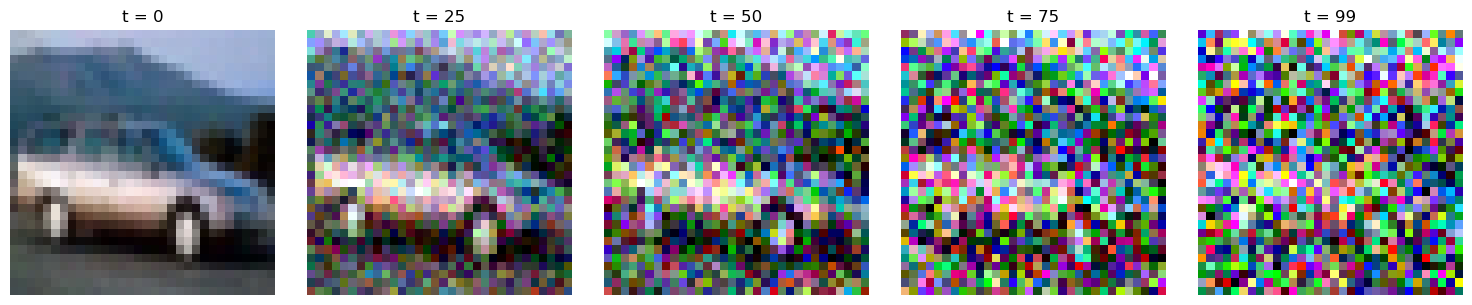

In [11]:
# time steps
T = 100
# create beta schedule
betas = linear_beta_schedule(timesteps=T)
# precompute terms
terms = precompute_terms(betas)
# define timesteps for visualization
timesteps_to_sample = [0, 25, 50, 75, 99]

# ectract single overfit image
x_0 = images_overfit[0].unsqueeze(0) # shape: (1, C, H, W)

# Generate noisy samples at the selected timesteps
noisy_images = []
for t_val in timesteps_to_sample:
    t_tensor = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diffusion_sample(
        x_0, 
        t_tensor, 
        terms["sqrt_alphas_cumprod"], 
        terms["sqrt_one_minus_alphas_cumprod"], 
        device="cpu"
    )
    noisy_images.append(noisy_img[0]) # Remove batch dimension

# Helper function to denormalize and convert tensor for plotting
def denormalize_and_to_numpy(tensor_image):
    """
    Denormalizes and converts a tensor image to numpy for plotting.(helperfunction)
    """
    # The original transform was Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # therefore apply the inverse transform: image * 0.5 + 0.5
    image = tensor_image.clone().detach()
    image = (image * 0.5) + 0.5
    # Clamp to [0,1] for plotting in rgb
    image = image.clamp(0,1)
    # Convert from Channels,Hight,Width (C,H,W) to H,W,C and to numpy
    image_np = image.permute(1,2,0).cpu()
    return image_np


# Plot the original and noisy samples
fig, axes = plt.subplots(1, len(timesteps_to_sample), figsize=(15, 3))
for ax, img, t in zip(axes, noisy_images, timesteps_to_sample):
    ax.imshow(denormalize_and_to_numpy(img))
    ax.set_title(f"t = {t}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Simple Diffusion

In [12]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        #self.bnorm1 = nn.BatchNorm2d(out_ch) #changed to groupnorm
        #self.bnorm2 = nn.BatchNorm2d(out_ch) #changed to groupnorm
        self.gnorm1 = nn.GroupNorm(32, out_ch)
        self.gnorm2 = nn.GroupNorm(32, out_ch)

        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        #h = self.bnorm1(self.relu(self.conv1(x)))# changed to gnorm
        h = self.gnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        # h = self.bnorm2(self.relu(self.conv2(h))) #changed to gnorm
        h = self.gnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

In [13]:
class SimpleUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 256 #changed from 32 and 64 and 128
        
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.SiLU() #changed from Relu to SiLU -> SiLU is a smooth version of ReLU and is good for diffusion models because can avoid dead neurons and smoother than ReLU. (but calculation takes longer)
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)


    def forward(self, x, timestep, y):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [14]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62730819


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=128, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=128, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


### Loss function

In [15]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device,label=None):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t, label)
    return F.mse_loss(noise, noise_pred)

 tried l1_loss and now mse_loss

### sampling

In [16]:
@torch.no_grad() # to prevent memory out of bounds
def sample_timestep(x, t,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance,y=None):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, y) / sqrt_one_minus_alphas_cumprod_t + 1e-5
    ) # 1e-5 is added to prevent division by zero
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.item() == 0:
        # The t's are offset from the t's in the paper https://arxiv.org/pdf/2006.11239
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(T, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas,
                     betas, model, posterior_variance, num_classes=None, labels_default:list=None, visualize=True, save=False):
    # Sample random noise
    img = torch.randn((1, 3, 32, 32), device=device)

    num_images = 10
    stepsize = int(T/num_images)
    generated_images = []

    if num_classes is None:
        if visualize:
            plt.figure(figsize=(15,15))
            plt.axis('off')

        for i in range(0, T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep(
                img, t,
                sqrt_one_minus_alphas_cumprod,
                sqrt_recip_alphas,
                betas, model,
                posterior_variance,
                y=None
            )
            
            if i % stepsize == 0:
                if visualize:
                    plt.subplot(1, num_images, int(i/stepsize)+1)
                    plt.imshow(denormalize_and_to_numpy(img[0]))
                    plt.axis('off')
                    
        if visualize:
            plt.imshow(denormalize_and_to_numpy(img[0]))
            plt.axis('off')
            plt.show()
        
        generated_unconditional = [img.clone(),None]
        generated_images.append(generated_unconditional)

    else:
        for label in range(num_classes):
            # Skip labels that are not in the default list
            if labels_default is not None and label not in labels_default:
                continue
                
            # for each label, generate new image
            img = torch.randn((1, 3, 32, 32), device=device)

            if visualize:
                plt.figure(figsize=(15,15))
                plt.axis('off')

            y = torch.tensor([label], dtype=torch.long, device=device)
                
            for i in range(0, T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
                t = torch.full((1,), i, device=device, dtype=torch.long)
                img = sample_timestep(
                    img, t,
                    sqrt_one_minus_alphas_cumprod,
                    sqrt_recip_alphas,
                    betas, model,
                    posterior_variance,
                    y=y
                )
                #img = torch.clamp(img, -1.0, 1.0) TODO: maybe use clamp
                
                if i % stepsize == 0:
                    if visualize:
                        plt.subplot(1, num_images, int(i/stepsize)+1)
                        plt.imshow(denormalize_and_to_numpy(img[0]))
                        plt.axis('off')
            
            if visualize:
                plt.imshow(denormalize_and_to_numpy(img[0]))
                plt.axis('off')
                plt.show()
            
            generated_conditional = [img.clone(),y]
            generated_images.append(generated_conditional)
    
    return generated_images

## overfittest

In [17]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="OverfitOneImage_lr1e-3_tdim256_t100")

wandb: Currently logged in as: floowbaumgartner. Use `wandb login --relogin` to force relogin


In [18]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #changed from 1e-4
epochs = 12_001
BATCH_SIZE = 1
T = 100 #TODO try 1000

  0%|          | 0/12001 [00:00<?, ?it/s]

Epoch 0 Loss: 1.011240005493164
Epoch 100 Loss: 0.20258037745952606


/tmp/ipykernel_168/1162404016.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


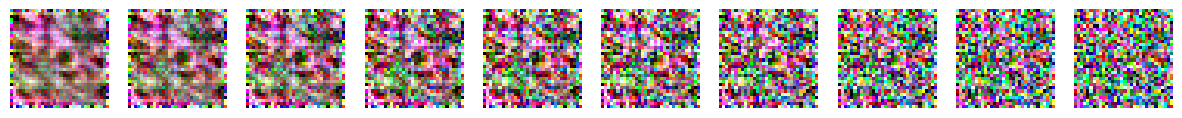

Epoch 200 Loss: 0.17038875818252563
Epoch 300 Loss: 0.09505297988653183
Epoch 400 Loss: 0.05487224459648132
Epoch 500 Loss: 0.07374027371406555
Epoch 600 Loss: 0.6053594946861267
Epoch 700 Loss: 0.03381185606122017
Epoch 800 Loss: 0.05662626773118973
Epoch 900 Loss: 0.05576664209365845
Epoch 1000 Loss: 0.033742506057024


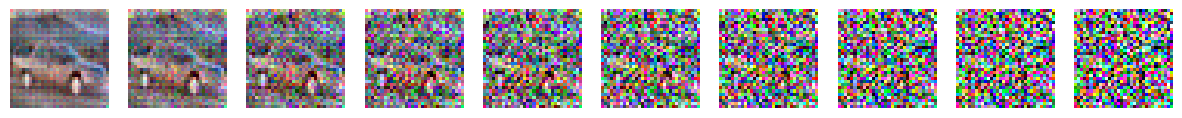

Epoch 1100 Loss: 0.06651979684829712
Epoch 1200 Loss: 0.07342381775379181
Epoch 1300 Loss: 0.020660292357206345
Epoch 1400 Loss: 0.052144914865493774
Epoch 1500 Loss: 0.13698747754096985
Epoch 1600 Loss: 0.019638918340206146
Epoch 1700 Loss: 0.10310264676809311
Epoch 1800 Loss: 0.05932880938053131
Epoch 1900 Loss: 0.062321893870830536
Epoch 2000 Loss: 0.03961643576622009
Epoch 2100 Loss: 0.028186848387122154
Epoch 2200 Loss: 0.05606205388903618
Epoch 2300 Loss: 0.01913107931613922
Epoch 2400 Loss: 0.017588965594768524
Epoch 2500 Loss: 0.03295118361711502
Epoch 2600 Loss: 0.059272896498441696
Epoch 2700 Loss: 0.02307206019759178
Epoch 2800 Loss: 0.040743138641119
Epoch 2900 Loss: 0.05103498324751854
Epoch 3000 Loss: 0.02086414024233818
Epoch 3100 Loss: 0.042226746678352356
Epoch 3200 Loss: 0.03750544786453247
Epoch 3300 Loss: 0.025454912334680557
Epoch 3400 Loss: 0.02676103077828884
Epoch 3500 Loss: 0.024303888902068138
Epoch 3600 Loss: 0.013014918193221092
Epoch 3700 Loss: 0.0240164455

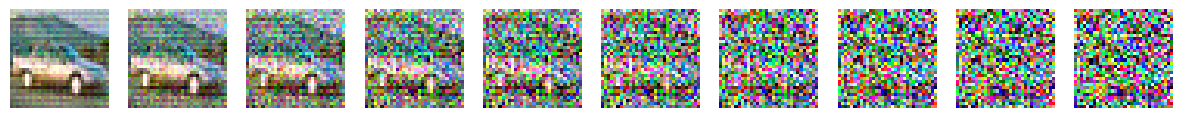

Epoch 5100 Loss: 0.12562678754329681
Epoch 5200 Loss: 0.03418942540884018
Epoch 5300 Loss: 0.03862188011407852
Epoch 5400 Loss: 0.017557669430971146
Epoch 5500 Loss: 0.15711641311645508
Epoch 5600 Loss: 0.009126960299909115
Epoch 5700 Loss: 0.0123505350202322
Epoch 5800 Loss: 0.23171328008174896
Epoch 5900 Loss: 0.011375673115253448
Epoch 6000 Loss: 0.011945030651986599
Epoch 6100 Loss: 0.2133524864912033
Epoch 6200 Loss: 0.09477442502975464
Epoch 6300 Loss: 0.015922077000141144
Epoch 6400 Loss: 0.011788127943873405
Epoch 6500 Loss: 0.019432950764894485
Epoch 6600 Loss: 0.020711133256554604
Epoch 6700 Loss: 0.008376738987863064
Epoch 6800 Loss: 0.015895158052444458
Epoch 6900 Loss: 0.017366057261824608
Epoch 7000 Loss: 0.0218354519456625
Epoch 7100 Loss: 0.019910577684640884
Epoch 7200 Loss: 0.016910281032323837
Epoch 7300 Loss: 0.028049286454916
Epoch 7400 Loss: 0.027366485446691513
Epoch 7500 Loss: 0.01038830541074276
Epoch 7600 Loss: 0.015465344302356243
Epoch 7700 Loss: 0.110083088

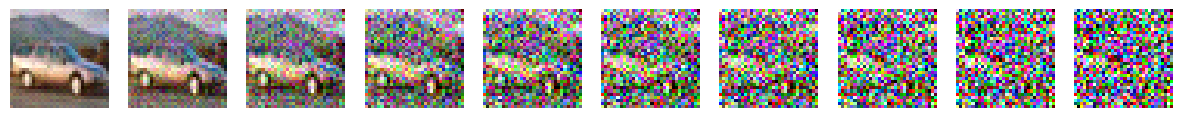

Epoch 10100 Loss: 0.011635071597993374
Epoch 10200 Loss: 0.0364934466779232
Epoch 10300 Loss: 0.0062292288057506084
Epoch 10400 Loss: 0.007934215478599072
Epoch 10500 Loss: 0.011855311691761017
Epoch 10600 Loss: 0.02162412367761135
Epoch 10700 Loss: 0.29633116722106934
Epoch 10800 Loss: 0.2907845973968506
Epoch 10900 Loss: 0.025691132992506027
Epoch 11000 Loss: 0.01382286474108696
Epoch 11100 Loss: 0.008105253800749779
Epoch 11200 Loss: 0.018569447100162506
Epoch 11300 Loss: 0.011927849613130093
Epoch 11400 Loss: 0.01584916189312935
Epoch 11500 Loss: 0.012641651555895805
Epoch 11600 Loss: 0.006466337945312262
Epoch 11700 Loss: 0.023861123248934746
Epoch 11800 Loss: 0.006384874694049358
Epoch 11900 Loss: 0.0066765835508704185
Epoch 12000 Loss: 0.007618659641593695


epoch,▁▂▄█
loss,█▂▁▂
epoch,10000
loss,0.03492


In [19]:
loss_history = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {100, 1000, 5000, 10_000, 12_000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model, terms["posterior_variance"])
                
                wandb.log({
                "epoch": epoch,
                "loss": loss.item(),
            })
            
wandb.finish()

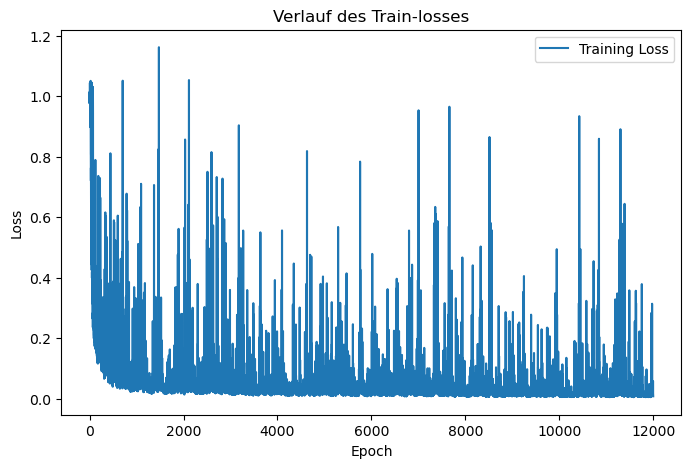

In [20]:
def plot_loss(loss_history):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Verlauf des Train-losses")
    plt.legend()
    plt.show()
    
plot_loss(loss_history)

### visualize generated images and compare to original

In [21]:
def compare_images(original, generated):
    """
    Zeigt Original und generiertes Bild nebeneinander in einem Plot an.
    original, generated: Tensors mit Shape (C, H, W)
    """
    orig_np = denormalize_and_to_numpy(original)
    gen_np = denormalize_and_to_numpy(generated)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(orig_np)
    axs[0].set_title("Original")
    axs[0].axis("off")
    
    axs[1].imshow(gen_np)
    axs[1].set_title("Generated")
    axs[1].axis("off")
    
    plt.show()

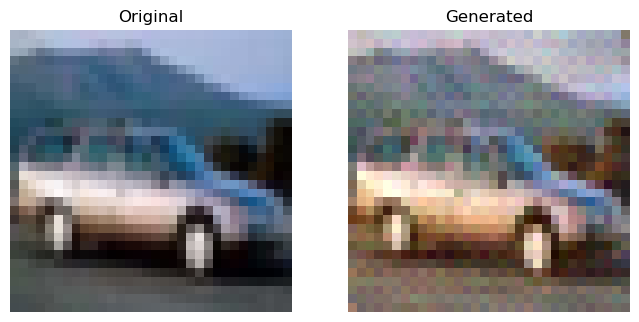

In [22]:
compare_images(images_overfit[0], x_gen[0][0].squeeze())

In [23]:
#TODO:take original image and generated image and calculate FID score

### conclusion
mit batchnorm wurde das bild mit der Zeit mit einem bestimmten farbton versehen (ab epoche 1000) mit groupnorm konnte ich das leider auch nicht verhindern, jedoch die genauigkeit der pixel wurde insgesamt besser (bis epoche 10'000). Was auffällt ist, dass die groupnorm bei den ersten schritten ein viel knalligeres bild erzeugt, als mit der batchnorm. Nach einigen hundert, gleicht es sich dann aus. Die groupnorm performt aber dann wieder bei hohen epochen (30'000) besser, es kommt zu originalen farben besser hin.

## train on full data from one label

In [24]:
model_simpleU = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model_simpleU.parameters()))
model_simpleU

Num params:  62730819


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=128, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=128, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [25]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_simpleU.to(device)
optimizer = torch.optim.Adam(model_simpleU.parameters(), lr=0.001)
epochs = 1_001
BATCH_SIZE = 128

In [26]:
train_1label =get_images_by_label(trainset, 1, 5_000)
print(f"Number of images in label 1 from trainset: {len(train_1label)}")

#init dataloader
trainloader_1label = torch.utils.data.DataLoader(train_1label, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Number of images in label 1 from trainset: 5000


In [27]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="one_label_bs128_lr1e-3_tdim256_t100")

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch 0 Loss: 0.212141215801239
Epoch 10 Loss: 0.13905182480812073


/tmp/ipykernel_168/1162404016.py:56: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


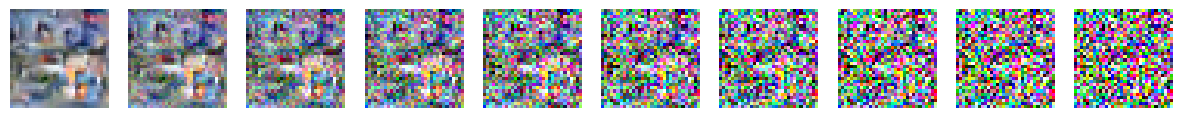

In [ ]:
loss_history_1label = []

for epoch in tqdm(range(epochs)):
    model_simpleU.train()
    for i, data in enumerate(trainloader_1label):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_simpleU, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
        loss.backward()
        optimizer.step()
        loss_history_1label.append(loss.item())
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {10, 50, 70, 90, 100, 200, 290, 300, 500, 800, 900, 990, 1000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"])
                
        wandb.log({
        "epoch": epoch,
        "loss": loss.item(),
    })
                
wandb.finish()

In [ ]:
plot_loss(loss_history_1label)

### visualize generated images and compare to original

In [ ]:
compare_images(train_1label[0], x_gen[0][0].squeeze())

In [ ]:
x_gen_1label_list = []
with torch.no_grad():
    for i in range(5):
        x_gen_1label = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"], visualize=False)
        x_gen_1label_list.append(x_gen_1label)

for x_gen in x_gen_1label_list:
    compare_images(train_1label[0], x_gen[0][0].squeeze())

### FID Score

In [ ]:
gen_1label_dir = './data/generated_1label'
real_1label_dir = './data/real_1label'
os.makedirs(gen_1label_dir, exist_ok=True)
os.makedirs(real_1label_dir, exist_ok=True)

In [ ]:
def save_gen_imgs(gen_dir,gen_images,name:str,label=None): 
    for i in range(len(gen_images)):
        for x_gen in gen_images:
            x_gen = denormalize_and_to_numpy(x_gen[i][0].squeeze())
            x_gen = torch.tensor(x_gen).permute(2,0,1)
            
            if label is not None:
                gen_dir = os.path.join(gen_dir, f'label_{label}')
                os.makedirs(gen_dir, exist_ok=True)
                
            vutils.save_image(
                x_gen, 
                os.path.join(gen_dir, f'gen_{name}.png')
            )
            

In [ ]:
num_gen_imgs = 1_000

# Generate and save images
with torch.no_grad():
    for i in range(num_gen_imgs):
        x_gen_1label = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"], visualize=False)
        save_gen_imgs(gen_1label_dir, x_gen_1label, i)

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

In [ ]:
# select the same label for the testset because the model was trained on this label
selected_label = 0

# find Indices of the label in testset
selected_indices = [i for i, label in enumerate(testset.targets) if label == selected_label]

# make subset
testset_1label = Subset(testset, selected_indices)

In [ ]:
#save real images
# for i in range(num_gen_imgs):
#    img, label = testset_1label[i]
#    vutils.save_image(
#        img, 
#        os.path.join(real_1label_dir, f'real_{i}.png')
#    )

In [ ]:
def calc_fid(real_dir, gen_dir):
    #calc fid score
    metrics_dict = calculate_metrics(
        input1=real_dir,
        input2=gen_dir,
        cuda=torch.cuda.is_available(),  
        isc=False,  # Inception Score not needed
        fid=True,   # FID needed
        kid=False,  
        verbose=True
    )
    
    print("FID Score:", metrics_dict["frechet_inception_distance"])


In [ ]:
calc_fid(real_1label_dir, gen_1label_dir)

In [ ]:
# TODO: FID Score
# TODO: ACHTUNG! testdaten enthalten alle labels, daher ist der FID score nicht aussagekräftig
# x_test_filtered = x_test[y_test.flatten() == selected_label]
# y_test_filtered = y_test[y_test.flatten() == selected_label]

### conclusion

In [ ]:
# TODO: Conclusion

### save model

In [ ]:
# Save params
checkpoint = {
    "epoch": epochs,
    "model_state_dict": model_simpleU.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}

torch.save(checkpoint, "checkpoint_simpleU.pt")

In [ ]:
#save model
torch.save(model_simpleU, "SimpleU_entire_model.pth")

## train on full data from all labels

In [ ]:
model_simpleU_all = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model_simpleU_all.parameters()))
model_simpleU_all

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_simpleU_all.to(device)
optimizer = torch.optim.Adam(model_simpleU_all.parameters(), lr=0.001)
epochs = 201
BATCH_SIZE = 128

In [ ]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="all_labels_bs128_lr1e-3_tdim256_t100")

In [ ]:
loss_history_all = []
for epoch in tqdm(range(epochs)):
    model_simpleU_all.train()
    for i, (data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_simpleU_all, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
        loss.backward()
        optimizer.step()
        loss_history_all.append(loss.item())
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {10, 100, 200, 300, 500, 700, 900, 1000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"])
                
        wandb.log({
        "epoch": epoch,
        "loss": loss.item(),
    })
                
wandb.finish()

In [ ]:
plot_loss(loss_history_all)

### visualize generated images and compare to original

In [ ]:
img_orig, label = trainloader.dataset[10_987]
compare_images(img_orig, x_gen[0][0].squeeze())

In [ ]:
x_gen_alllabel_list = []
with torch.no_grad():
    for i in range(5):
        x_gen_alllabel = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU_all, terms["posterior_variance"], visualize=False)
        x_gen_alllabel_list.append(x_gen_alllabel)

for x_gen in x_gen_1label_list:
    compare_images(img_orig, x_gen[0][0].squeeze())

### FID Score

In [ ]:
gen_dir = './data/generated'
real_dir = './data/real'
os.makedirs(gen_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)

In [ ]:
num_gen_imgs = 1_000

# Generate and save images
with torch.no_grad():
    for i in range(num_gen_imgs):
        x_gen_all = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU_all, terms["posterior_variance"], visualize=False)
        save_gen_imgs(gen_dir,x_gen_all, i)

In [ ]:
testloader_fid = torch.utils.data.DataLoader(testset, batch_size=num_gen_imgs, shuffle=True)

# save real images
# for i in range(num_gen_imgs):
#     img, label = testloader_fid.dataset[i]
#     vutils.save_image(
#         img, 
#         os.path.join(real_dir, f'real_{i}.png')
#    )

In [ ]:
calc_fid(real_dir, gen_dir)

### conclusion

In [ ]:
# TODO: Conclusion

# conditonal diffusion model

In [ ]:
class ConditionalUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self, num_classes=None):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 256 # TODO: changed from 32 and 64 and 128
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.SiLU() #changed from Relu to SiLU -> SiLU is a smooth version of ReLU and is good for diffusion models because can avoid dead neurons and smoother than ReLU. (but calculation takes longer)
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)
        
        # Conditional classes
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_emb_dim)


    def forward(self, x, timestep, y):
        # Embedd time
        t = self.time_mlp(timestep)
        
        #conditional
        if y is not None:
            t += self.label_emb(y)
        
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

## overfittest

In [ ]:
num_classes = 2
model_cond = ConditionalUnet(num_classes=num_classes)
print("Num params: ", sum(p.numel() for p in model_cond.parameters()))
model_cond

In [ ]:
T = 100 #TODO 1000?
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_cond.to(device)
optimizer = torch.optim.Adam(model_cond.parameters(), lr=0.001)
epochs = 5_001
BATCH_SIZE = 2

In [ ]:
desired_labels = [0, 1]  
desired_indices = []

# go through the dataset and pick the first image for each desired label
found_labels = set()

for idx, (_, label) in enumerate(trainset):
    if label in desired_labels and label not in found_labels:
        desired_indices.append(idx)
        found_labels.add(label)
    # Stop if found at least one sample for each desired label
    if len(found_labels) == len(desired_labels):
        break

#Create a Subset
trainset_cond_subset = Subset(trainset, desired_indices)

In [ ]:
trainloader_cond_subset = torch.utils.data.DataLoader(trainset_cond_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
wandb.init(project="Conditional-Diffusion", entity="floowbaumgartner", name="overfit_2labels_lr1e-3_tdim256_t100")

In [ ]:
loss_history_cond_oft = []

for epoch in tqdm(range(epochs)):
    model_cond.train()
    for i, (data, label) in enumerate(trainloader_cond_subset):
        optimizer.zero_grad()
        label = label.to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_cond, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device, label)
        loss.backward()
        optimizer.step()
        loss_history_cond_oft.append(loss.item())
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {100, 200, 500, 700, 1000, 2000, 3000, 4000, 5000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond, terms["posterior_variance"],num_classes)
                
        wandb.log({
        "epoch": epoch,
        "loss": loss.item(),
    })
                
wandb.finish()

In [ ]:
plot_loss(loss_history_cond_oft)

### visualize generated images and compare to original

In [ ]:
with torch.no_grad():
    x_gen_cond_label = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond, terms["posterior_variance"],num_classes=2, visualize=False, labels_default=[0,1])
    compare_images(trainloader_cond_subset.dataset[0][0], x_gen_cond_label[1][0].squeeze())
    compare_images(trainloader_cond_subset.dataset[1][0], x_gen_cond_label[0][0].squeeze())

### FID Score

In [ ]:
# TODO: FID Score TAKE the 2 pictures and compare them to the real images

### conclusion

In [ ]:
# TODO: Conclusion

## train on full data with all labels

In [ ]:
num_classes = 10
model_cond_all = ConditionalUnet(num_classes=num_classes)
print("Num params: ", sum(p.numel() for p in model_cond_all.parameters()))
model_cond_all

In [ ]:
T = 100 #TODO 1000?
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_cond_all.to(device)
optimizer = torch.optim.Adam(model_cond_all.parameters(), lr=0.001)
epochs = 201
BATCH_SIZE = 128

In [ ]:
trainloader_cond = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
wandb.init(project="Conditional-Diffusion", entity="floowbaumgartner", name="conditional_bs256_lr1e-3_tdim128_t100")

In [ ]:
loss_history_cond = []
for epoch in tqdm(range(epochs)):
    model_cond_all.train()
    for i, (data, label) in enumerate(trainloader_cond):
        optimizer.zero_grad()
        label = label.to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_cond_all, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"],
                        device, label)
        loss.backward()
        optimizer.step()
        loss_history_cond.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")

        if epoch in {10, 50, 100, 150, 200, 300, 500}:
            with torch.no_grad():
                x_gen = sample_plot_image(T, terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond_all, terms["posterior_variance"], num_classes)

        wandb.log({
            "epoch": epoch,
            "loss": loss.item(),
        })

wandb.finish()

In [ ]:
plot_loss(loss_history_cond)

### visualize generated images and compare to original

In [ ]:
try:
    one_image_per_label = []
    for img_trainset, label_trainset in trainset:
        if label_trainset not in found_labels:
            found_labels.add(label_trainset)
            one_image_per_label.append((img_trainset, label_trainset))
        if len(found_labels) == 10:
            break
    
    with torch.no_grad():
        x_gen_cond = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond_all, terms["posterior_variance"],num_classes=10, visualize=False, labels_default=[0,1,2,3,4,5,6,7,8,9])
        for i in range(10):
            compare_images(one_image_per_label[i], x_gen_cond[i][0].squeeze())

except:
    continue

In [ ]:
# TODO: visualize generated images and compare to original

### FID Score

In [ ]:
gen_cond_dir = r'.\data\generated_cond'
real_cond_dir = r'.\data\real_cond'
os.makedirs(gen_cond_dir, exist_ok=True)
os.makedirs(real_cond_dir, exist_ok=True)

In [ ]:
num_gen_imgs = 1_000

# Generate and save images
with torch.no_grad():
    for i in range(num_gen_imgs):
        for label_num in range(num_classes):
            x_gen_cond_ = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond_all, terms["posterior_variance"],num_classes=num_classes, visualize=False, labels_default=[label_num])
            save_gen_imgs(gen_cond_dir,x_gen_cond_, i,label=label_num)

In [ ]:
for selected_label in range(num_classes):
    real_cond_dir = real_cond_dir + f'\label_{selected_label}'
    gen_cond_dir = gen_cond_dir + f'\label_{selected_label}'
    print(gen_cond_dir)
    os.makedirs(real_cond_dir, exist_ok=True)
    # find Indices of the label in testset
    selected_indices = [i for i, label in enumerate(testset.targets) if label == selected_label]

    testset_label = Subset(testset, selected_indices)
    #save real images
    for j in range(num_gen_imgs):
        img, label = testset_label[j]
        
        vutils.save_image(
            img,
            real_cond_dir + f'real_{j}.png'
        )

    calc_fid(real_cond_dir, gen_cond_dir)

In [ ]:
# TODO: FID Score

### conclusion

In [ ]:
# TODO: Conclusion

# examples of generated images with different default labels

In [ ]:
# TODO: examples of generated images with different default labels

# summary

In [ ]:
# TODo: do bottleneck

# fragen:
TODO:
diagnostische plots -> wandb
wie testen -> qualität eines generativen modells testen